In [1]:
cd ..

/Users/charlesp/Documents/Projects/hacker_news_NLP_score_prediction/predict


In [2]:
from process import Process

In [3]:
p = Process()

INFO:root:Creating connection to hn_db...
INFO:root:Successfully connected.
INFO:root:Retrieved posts from database
INFO:root:Closing DB Connection.


In [4]:
p.posts.head()

,id,title,url,type,score,timestamp
0,3676512,New iPad is official: 2048x1536 retina display,http://www.engadget.com/2012/03/07/the-new-ipa...,story,18,2012-03-07 18:28:01
1,22034463,The Art of Problem-Solving,https://amymhaddad.com/the-art-of-problem-solving,story,2,2020-01-13 13:57:43
2,752581,Twitter is for Old People,http://crenk.com/twitter-is-for-old-people/,story,1,2009-08-10 11:37:22
3,8176404,President Obama: No Internet Fast Lanes,http://www.nytimes.com/2014/08/14/opinion/pres...,story,2,2014-08-14 07:18:32
4,8160475,Free Photo Editing Software Lets You Manipulat...,http://reframe.gizmodo.com/free-photo-editing-...,story,2,2014-08-10 19:32:42


In [5]:
p.posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509434 entries, 0 to 3509433
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   id         Int64         
 1   title      string        
 2   url        string        
 3   type       string        
 4   score      Int64         
 5   timestamp  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), string(3)
memory usage: 167.3 MB


## What's The Average Length Of A Post ?
This will inform our custom initialization of the model's block size. Hacker News has a general 80 word limit on all of it's posts but many posts might come in lower than this on average. 

In [6]:
p.posts['len'] = p.posts.title.str.len()

In [7]:
p.posts.head()

,id,title,url,type,score,timestamp,len
0,3676512,New iPad is official: 2048x1536 retina display,http://www.engadget.com/2012/03/07/the-new-ipa...,story,18,2012-03-07 18:28:01,46
1,22034463,The Art of Problem-Solving,https://amymhaddad.com/the-art-of-problem-solving,story,2,2020-01-13 13:57:43,26
2,752581,Twitter is for Old People,http://crenk.com/twitter-is-for-old-people/,story,1,2009-08-10 11:37:22,25
3,8176404,President Obama: No Internet Fast Lanes,http://www.nytimes.com/2014/08/14/opinion/pres...,story,2,2014-08-14 07:18:32,39
4,8160475,Free Photo Editing Software Lets You Manipulat...,http://reframe.gizmodo.com/free-photo-editing-...,story,2,2014-08-10 19:32:42,61


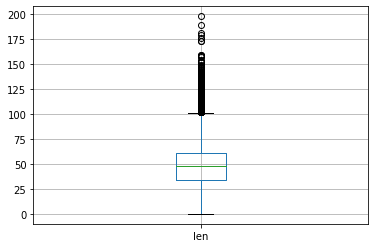

In [9]:
p.posts.boxplot(column ='len')

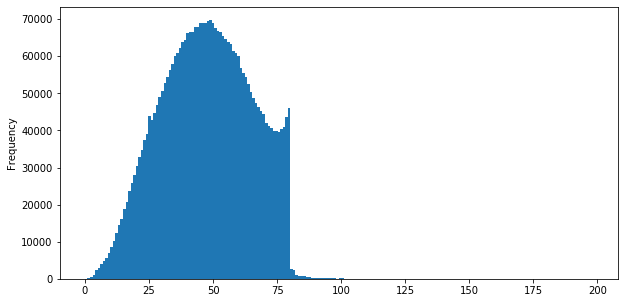

In [10]:
p.posts.len.plot.hist(figsize=(10,5),bins=200)

In [11]:
for i in range(50,100,5):
    word_perc = p.posts[p.posts.title.str.len() <= i].shape[0] / len(p.posts) * 100
    print(f"% of posts less than or equal to {i} words is {word_perc}%")

% of posts less than or equal to 50 words is 55.337099942611836%
% of posts less than or equal to 55 words is 64.76474554016403%
% of posts less than or equal to 60 words is 73.58377447759382%
% of posts less than or equal to 65 words is 81.26264805093926%
% of posts less than or equal to 70 words is 87.88018238838514%
% of posts less than or equal to 75 words is 93.6755043690806%
% of posts less than or equal to 80 words is 99.67325215405106%
% of posts less than or equal to 85 words is 99.89123602267487%
% of posts less than or equal to 90 words is 99.95594731230165%
% of posts less than or equal to 95 words is 99.9732435486748%


# Prepend Domains to Every Post Title
Along with the text of posts there is also a strong chance that there will be a domain attached as the source of the link. These domains themselves might contain useful information as how succesful a post will be e.g. A post discussing data science from Medium.com does generally does well. 

To account for this I'm going to prepend every post title with the domain from which it came. 

In [32]:
def prepend_domain_name(r):
    url = r.url
    if url == "empty":
        r.title = "empty :- " + r.title
        return r.title
    else:
        domain = Process.extract_domain(url)
        r.title = domain.domain + " :- " + r.title
        return r.title
        
    

In [33]:
p.posts.url.value_counts()[0:100]

empty                                            216338
https://news.ycombinator.com/bookmarklet.html      1755
http://ycombinator.com/bookmarklet.html             695
http://www.ezy-bid.com                              197
https://www.easypost.com/jobs                       177
                                                  ...  
                                                     31
http://www.beautiful-legs-again.com/                 31
http://mlhelper.luoxia.me:8080                       31
https://www.fsf.org/                                 31
http://www.abudhabi-sex.com/                         30
Name: url, Length: 100, dtype: Int64

In [19]:
import tqdm

In [26]:
temp_posts = p.posts[:10_000]

In [34]:
p.posts['title'] = p.posts.apply(prepend_domain_name, axis= 1)

In [38]:
p.posts.head(10)

,id,title,url,type,score,timestamp,len
0,3676512,engadget :- New iPad is official: 2048x1536 re...,http://www.engadget.com/2012/03/07/the-new-ipa...,story,18,2012-03-07 18:28:01,46
1,22034463,amymhaddad :- The Art of Problem-Solving,https://amymhaddad.com/the-art-of-problem-solving,story,2,2020-01-13 13:57:43,26
2,752581,crenk :- Twitter is for Old People,http://crenk.com/twitter-is-for-old-people/,story,1,2009-08-10 11:37:22,25
3,8176404,nytimes :- President Obama: No Internet Fast L...,http://www.nytimes.com/2014/08/14/opinion/pres...,story,2,2014-08-14 07:18:32,39
4,8160475,gizmodo :- Free Photo Editing Software Lets Yo...,http://reframe.gizmodo.com/free-photo-editing-...,story,2,2014-08-10 19:32:42,61
5,2532794,victusspiritus :- Duostack vs Nodester Node.js...,http://www.victusspiritus.com/2011/05/10/duost...,story,1,2011-05-10 15:31:10,46
6,1187681,zpub :- In Praise of Idleness,http://www.zpub.com/notes/idle.html,story,26,2010-03-12 20:15:35,21
7,6733429,freebeacon :- Court: Homeland Security Must Di...,http://freebeacon.com/court-homeland-security-...,story,2,2013-11-14 16:58:22,61
8,14420226,erickarjaluoto :- Don’t Be a Crehater,http://www.erickarjaluoto.com/blog/dont-be-a-c...,story,1,2017-05-25 21:20:37,19
9,12589532,time :- Unsafe Air-Pollution Levels Affect 9 i...,http://time.com/4508028/air-pollution-global-h...,story,5,2016-09-27 13:47:52,58


In [42]:
from string import punctuation


In [43]:
def remove_punctuation(s):
        "Must come first"
        return s.translate(str.maketrans('', '', punctuation))

In [48]:
def title_to_lower(s):
    return s.lower()

In [49]:
p.posts['title'] = p.posts['title'].apply(title_to_lower)

In [44]:
p.posts['title'] = p.posts['title'].apply(remove_punctuation)

In [50]:
p.posts.head()

,id,title,url,type,score,timestamp,len
0,3676512,engadget new ipad is official 2048x1536 retin...,http://www.engadget.com/2012/03/07/the-new-ipa...,story,18,2012-03-07 18:28:01,46
1,22034463,amymhaddad the art of problemsolving,https://amymhaddad.com/the-art-of-problem-solving,story,2,2020-01-13 13:57:43,26
2,752581,crenk twitter is for old people,http://crenk.com/twitter-is-for-old-people/,story,1,2009-08-10 11:37:22,25
3,8176404,nytimes president obama no internet fast lanes,http://www.nytimes.com/2014/08/14/opinion/pres...,story,2,2014-08-14 07:18:32,39
4,8160475,gizmodo free photo editing software lets you ...,http://reframe.gizmodo.com/free-photo-editing-...,story,2,2014-08-10 19:32:42,61


# Analysing Scores
We are going to be trying to predict scores. It will be useful here to look at how scores are distributed, and what the average/mean and median score are. This will help us establish a simple baseline model that predicts the average each time. 

In [73]:
p.posts.score.mean()

11.962646398251113

In [ ]:
p.posts.score.value_counts().plot.hist(figsize=(10,5),bins=200).set_xlim(left=0, right=50)